This notebook is adapted from https://github.com/jwoerner42/LCW-Fine-Tuning-ChemBERTa-2.git

In [1]:
# Released under MIT License
#
# Copyright (c) 2023 Andrew SID Lang, Oral Roberts University, U.S.A.
#
# Copyright (c) 2023 Jan HR Woerner, Oral Roberts University, U.S.A.
#
# Copyright (c) 2023 Wei-Khiong (Wyatt) Chong, Advent Polytech Co., Ltd, Taiwan.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
# permit persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
# Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO
# THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS
# OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
# OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import torch
from torch.utils.data import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0, but all input tensors were scalars")

/home/elisa/miniconda3/envs/recom_sys_qm9_new/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class Input(Dataset):
    def __init__(self, i_data, i_tokenizer, i_max_length):
        self.data = i_data
        self.tokenizer = i_tokenizer
        self.max_length = i_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        i_smiles = self.data.iloc[idx]["CANONICAL_SMILES"]
        i_inputs = self.tokenizer(i_smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length)
        i_inputs["input_ids"] = i_inputs["input_ids"].squeeze(0)
        i_inputs["attention_mask"] = i_inputs["attention_mask"].squeeze(0)
        if "token_type_ids" in i_inputs:
            i_inputs["token_type_ids"] = i_inputs["token_type_ids"].squeeze(0)
        i_inputs["labels"] = torch.tensor(self.data.iloc[idx]["PBE_TZP"], dtype=torch.float).unsqueeze(0)
        return i_inputs

# Prepare Data
(MultiXC-QM9 dataset with PBE_TZP column, which corresponds to Atomization Energy)

In [3]:
# Load the dataset
df = pd.read_csv("data/qm9_recommended_data_canonical.csv")
print(f'Number of examples is: {len(df)}')
df.head()

Number of examples is: 133055


,PBE_TZP,B3LYP(VWN5)_TZP,GFNXTB,M06-2X_TZP,smiles,chemformula,index,CANONICAL_SMILES
0,-18.261372,-19.140565,-21.979934,-19.987828,[H]C([H])([H])[H],CH4,1,[H]C([H])([H])[H]
1,-12.975380,-12.896428,-17.405808,-12.694483,[H]N([H])[H],H3N,2,[H]N([H])[H]
2,-10.370616,-11.226953,-14.033122,-12.538535,[H]O[H],H2O,3,[H]O[H]
3,-18.070231,-19.266542,-22.665365,-21.246587,[H]C#C[H],C2H2,4,[H]C#C[H]
4,-14.127323,-14.386552,-19.345571,-15.292001,[H]C#N,CHN,5,[H]C#N


In [4]:
# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=21)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=21)
print(f"There are {len(train_df)} molecules in Train df.")
print(f"There are {len(val_df)} molecules in Val df.")
print(f"There are {len(test_df)} molecules in Test df.")

There are 106444 molecules in Train df.
There are 13305 molecules in Val df.
There are 13306 molecules in Test df.


In [5]:
# pick out columns
data = train_df[['CANONICAL_SMILES', 'PBE_TZP']]
test = test_df[['CANONICAL_SMILES', 'PBE_TZP']]

## Load pre-trained ChemBERta model

In [6]:
# Load a pretrained transformer model and tokenizer
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

#see if GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
# move model to the device
model.to(device) 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using GPU.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
         

# Fine tuning

In [11]:
# max length of SMILES over both sets
max_length = 512
# Prepare the dataset for training
train_dataset = Input(data, tokenizer,max_length)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=100, # Number of training epochs
    per_device_train_batch_size=86, # Batch size
    logging_steps=100,  # Log training metrics every 100 steps
    optim="adamw_torch", # switch optimizer to avoid warning
    seed=123, # Set a random seed for reproducibility
    report_to="none", # Disable reporting to avoid warnings
)

    
# Train the model
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset,)
trainer.train() 
trainer.save_model("./output") # save model to output folder

Step,Training Loss
100,6488.631300
200,5601.507500
300,5270.255000
400,4967.762800
500,4698.678100
600,4437.788700
700,4204.670300
800,3932.456600
900,3700.745300
1000,3465.623100


KeyboardInterrupt: 

In [ ]:
# Save the model
trainer.save_model("./output_final") # save model to output folder

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained("./output_final_tokenizer")  # Optional, but saves tokenizer too

('./output_final_tokenizer/tokenizer_config.json',
 './output_final_tokenizer/special_tokens_map.json',
 './output_final_tokenizer/vocab.json',
 './output_final_tokenizer/merges.txt',
 './output_final_tokenizer/added_tokens.json',
 './output_final_tokenizer/tokenizer.json')

# Predict on test set

In [ ]:
from transformers import pipeline
# Create a prediction pipeline

#predictor = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Prepare new SMILES strings for prediction
test_smiles = test['CANONICAL_SMILES']

# Predict properties for new SMILES strings
predictions = []
for smiles in test_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    predictions.append(predicted_property)

TEST SET
N: 13306
R2: 0.9588689312100349
Root Mean Square Error: 2.219926884445701
Mean Absolute Error: 1.7387904082140189
Spearman correlation: 0.978571264012483
p-value: 0.0


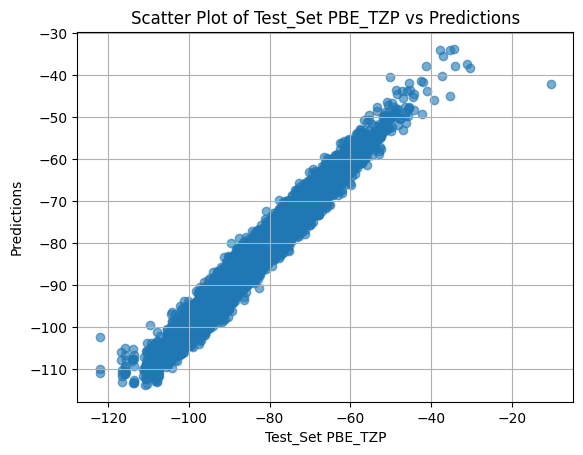

In [19]:
# Adjusted for python 3.13+

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions is a list or array of floats
predictions_float = [float(p) for p in predictions]

# RMSE (manual square root)
mse = mean_squared_error(test["PBE_TZP"], predictions_float)
r_mse = np.sqrt(mse)
r2 = r2_score(test["PBE_TZP"], predictions_float)
mae = mean_absolute_error(test["PBE_TZP"], predictions_float)

print("TEST SET")
print("N:", len(test["PBE_TZP"]))
print("R2:", r2)
print("Root Mean Square Error:", r_mse)
print("Mean Absolute Error:", mae)

# Spearman correlation
correlation, p_value = spearmanr(test["PBE_TZP"], predictions_float)
print("Spearman correlation:", correlation)
print("p-value:", p_value)

# Plot
plt.scatter(test["PBE_TZP"], predictions_float, alpha=0.6)
plt.xlabel("Test_Set PBE_TZP")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Test_Set PBE_TZP vs Predictions")
plt.grid(True)
plt.show()


## A prettier plot 🎀

findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font famil

🌸 TEST SET 🌸
N: 13306
R²: 0.9589
RMSE: 2.2199
MAE: 1.7388
Spearman correlation: 0.9786
p-value: 0.00e+00


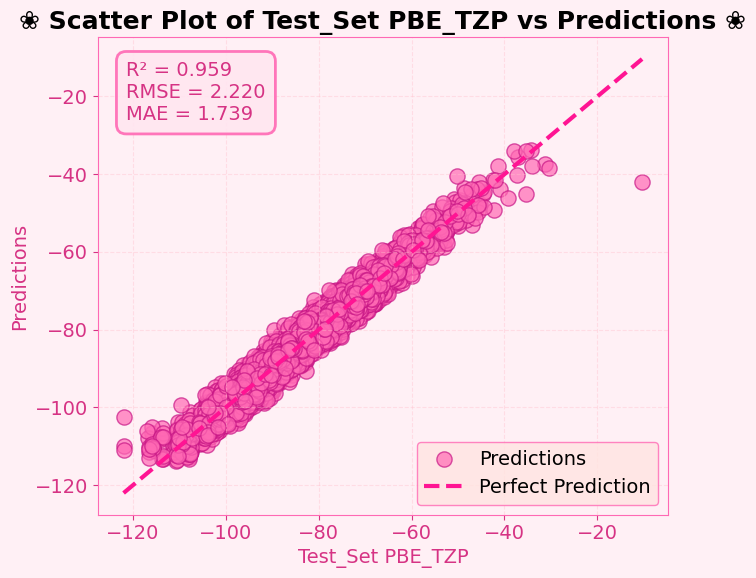

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to float (safety)
predictions_float = [float(p) for p in predictions]

# Metrics
mse = mean_squared_error(test["PBE_TZP"], predictions_float)
rmse = np.sqrt(mse)
r2 = r2_score(test["PBE_TZP"], predictions_float)
mae = mean_absolute_error(test["PBE_TZP"], predictions_float)

print("🌸 TEST SET 🌸")
print("N:", len(test["PBE_TZP"]))
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Spearman correlation
correlation, p_value = spearmanr(test["PBE_TZP"], predictions_float)
print(f"Spearman correlation: {correlation:.4f}")
print(f"p-value: {p_value:.2e}")

# Plot styling - kawaii theme
plt.rcParams.update({
    'font.size': 14,
    'axes.edgecolor': '#ff69b4',
    'axes.labelcolor': '#d63384',
    'xtick.color': '#d63384',
    'ytick.color': '#d63384',
    'axes.titlesize': 18,
    'axes.titleweight': 'bold'
})

bg_color = '#fff0f5'
point_color = '#ff69b4'
line_color = '#ff1493'
grid_color = '#ffc0cb'

fig, ax = plt.subplots(figsize=(7, 6))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Scatter points
ax.scatter(
    test["PBE_TZP"], predictions_float,
    color=point_color,
    edgecolors='#c71585',
    s=120,
    alpha=0.7,
    label="Predictions"
)

# Diagonal perfect prediction line
min_val = min(test["PBE_TZP"].min(), min(predictions_float))
max_val = max(test["PBE_TZP"].max(), max(predictions_float))
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    color=line_color, linewidth=3, linestyle='--', label='Perfect Prediction'
)

ax.set_xlabel("Test_Set PBE_TZP")
ax.set_ylabel("Predictions")
ax.set_title("❀ Scatter Plot of Test_Set PBE_TZP vs Predictions ❀")

ax.grid(True, linestyle='--', color=grid_color, alpha=0.4)
ax.legend(frameon=True, facecolor='mistyrose', edgecolor='#ff69b4')

# Add metrics box
metrics_text = (
    f"R² = {r2:.3f}\n"
    f"RMSE = {rmse:.3f}\n"
    f"MAE = {mae:.3f}"
)

bbox_props = dict(boxstyle="round,pad=0.5", facecolor="#ffe6f0", edgecolor="#ff69b4", linewidth=2, alpha=0.9)
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=bbox_props, color="#d63384")

plt.tight_layout()
plt.show()


# Predict on train set

In [20]:
# Prepare new SMILES strings for prediction
train_smiles = data['CANONICAL_SMILES']

# Predict properties for new SMILES strings
train_predictions = []
for smiles in train_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device) 
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    train_predictions.append(predicted_property)

TRAINING SET
N: 106444
R2: 0.9602471807005237
Root Mean Square Error: 2.2050128505190063
Mean Absolute Error: 1.7418238829738775
Spearman correlation: 0.9787730931193688
p-value: 0.0


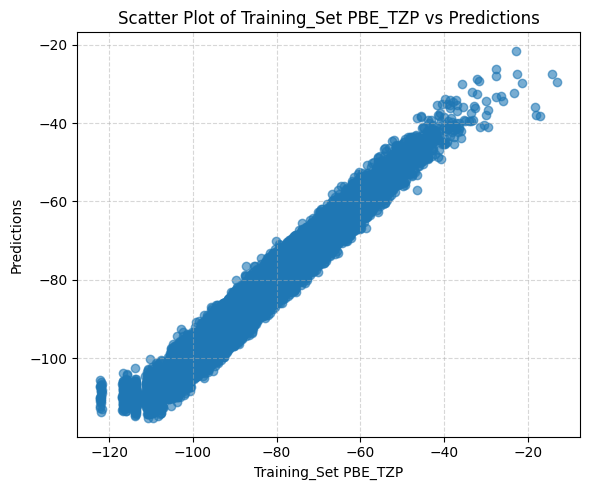

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

# Compute metrics
mse = mean_squared_error(data["PBE_TZP"], train_predictions)
rmse = np.sqrt(mse)  # manually compute RMSE
r2 = r2_score(data["PBE_TZP"], train_predictions)
mae = mean_absolute_error(data["PBE_TZP"], train_predictions)

print("TRAINING SET")
print("N:", len(data["PBE_TZP"]))
print("R2:", r2)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# Spearman correlation
correlation, p_value = spearmanr(data["PBE_TZP"], train_predictions)
print("Spearman correlation:", correlation)
print("p-value:", p_value)

# Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(data["PBE_TZP"], train_predictions, alpha=0.6)
plt.xlabel("Training_Set PBE_TZP")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Training_Set PBE_TZP vs Predictions")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## A prettier plot 🎀

findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.


🌸 TRAINING SET 🌸
N: 106444
R²: 0.9602
RMSE: 2.205
MAE: 1.7418
Spearman Correlation: 0.9788
p-value: 0.00e+00


findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font famil

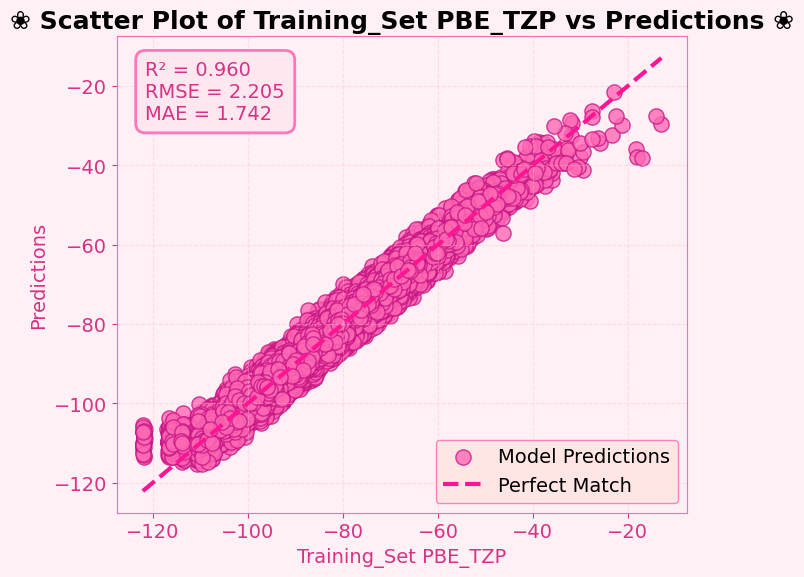

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr

# Compute metrics
mse = mean_squared_error(data["PBE_TZP"], train_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(data["PBE_TZP"], train_predictions)
mae = mean_absolute_error(data["PBE_TZP"], train_predictions)

# Spearman correlation
correlation, p_value = spearmanr(data["PBE_TZP"], train_predictions)

# Print results
print("🌸 TRAINING SET 🌸")
print("N:", len(data["PBE_TZP"]))
print("R²:", round(r2, 4))
print("RMSE:", round(rmse, 4))
print("MAE:", round(mae, 4))
print("Spearman Correlation:", round(correlation, 4))
print("p-value:", format(p_value, ".2e"))

# Try Comic Sans or fallback to DejaVu Sans
plt.rcParams.update({
    'font.size': 14,
    'axes.edgecolor': '#ff69b4',
    'axes.labelcolor': '#d63384',
    'xtick.color': '#d63384',
    'ytick.color': '#d63384',
    'axes.titlesize': 18,
    'axes.titleweight': 'bold'
})

# Kawaii colors
bg_color = '#fff0f5'
point_color = '#ff69b4'
line_color = '#ff1493'
grid_color = '#ffc0cb'

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

ax.scatter(
    data["PBE_TZP"], train_predictions,
    color=point_color,
    edgecolors='#c71585',
    s=120,
    marker='o',
    alpha=0.8,
    label="Model Predictions"
)

ax.plot(
    [min(data["PBE_TZP"]), max(data["PBE_TZP"])],
    [min(data["PBE_TZP"]), max(data["PBE_TZP"])],
    color=line_color, linewidth=3, linestyle='--', label='Perfect Match'
)

ax.set_xlabel("Training_Set PBE_TZP")
ax.set_ylabel("Predictions")
ax.set_title("❀ Scatter Plot of Training_Set PBE_TZP vs Predictions ❀")

ax.grid(True, linestyle='--', color=grid_color, alpha=0.4)
ax.legend(frameon=True, facecolor='mistyrose', edgecolor='#ff69b4')

# Add metrics box
metrics_text = (
    f"R² = {r2:.3f}\n"
    f"RMSE = {rmse:.3f}\n"
    f"MAE = {mae:.3f}"
)

bbox_props = dict(boxstyle="round,pad=0.5", facecolor="#ffe6f0", edgecolor="#ff69b4", linewidth=2, alpha=0.9)
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=bbox_props, color="#d63384")

plt.tight_layout()
plt.show()


## Example for loading the model and predict

In [55]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

loaded_model = AutoModelForSequenceClassification.from_pretrained("./output_final")
loaded_tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR") # Or load the tokenizer from the saved model

In [56]:
# Test on a smiles from the training set
example_smiles = train_df.iloc[0]['smiles']
example_smiles

'[H]C#C[C@]12N([H])C(=O)[C@]([H])(C1([H])[H])C2([H])[H]'

In [57]:
true_value = train_df.iloc[0]['PBE_TZP'] 
print(f"True value: {true_value}")

True value: -78.86502657900002


In [59]:
import torch

smiles = "[H]C#C[C@]12N([H])C(=O)[C@]([H])(C1([H])[H])C2([H])[H]"  
inputs = loaded_tokenizer(smiles, return_tensors="pt", max_length=512, padding="max_length", truncation=True)

# Move inputs to the correct device
inputs = {k: v.to(loaded_model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = loaded_model(**inputs)
    prediction = outputs.logits.item()  # since it's a regression task

print("Predicted value:", prediction)

Predicted value: -80.21450805664062
